In [71]:
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.path import Path as mPath
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle

import scipy.io as sio
from scipy import stats
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample_poly
from sklearn.model_selection import KFold

import nemos as nmo
import jax.numpy as jnp

from utils import load_pickle,extract_used_data,mergeAB,set_params
from utils.config import Params

import ipywidgets as widgets
from IPython.display import display

import joblib
import contextlib
from joblib import Parallel, delayed
from tqdm.auto import tqdm

In [72]:
def align_track(data: dict, params: Params):
    
    aligned_firing = np.empty_like(data["simple_firing"],dtype=object)
    aligned_firing_std = np.empty_like(data["simple_firing"],dtype=object)
    
    for index in params.total_index_grid:
        
        fr = data["simple_firing"][index]
        if fr is None:
            continue

        if params.gaussian_sigma > 0:
            fr = gaussian_filter1d(fr, sigma=params.gaussian_sigma, axis=2,
                                    mode="nearest", truncate=3.0)
        
        fr_mean = np.mean(fr, axis=1)
        fr_std = np.std(fr, axis=1) / np.sqrt(fr.shape[1])

        aligned_firing[index] = fr_mean
        aligned_firing_std[index] = fr_std
    
    aligned_zones_id = np.empty_like(data["zones"],dtype=int)
    zones = data["zones"]
    for i in range(len(zones)):
        offset = 0
        start = int(zones[i][0] / params.space_unit - offset) - 1
        end = int(zones[i][1] / params.space_unit - offset) + 1
        start = max(start, 0)
        end = min(end, params.len_track)
        aligned_zones_id[i] = [start, end]
        
    data["aligned_firing"] = aligned_firing
    data["aligned_zones_id"] = aligned_zones_id
    data["aligned_firing_std"] = aligned_firing_std

In [73]:

def plot_neuron_id(
    data: dict,
    params: Params,
    rule1: str,
    rule2: str,
    id: int,
    alpha=0.9,
    lw=1.5,
):
    color_map = {
        "pattern_1": "#1f77b4",
        "pattern_2": "#ff7f0e",
        "pattern_3": "#d62728",
        "position_1": "#1f77b4",
        "position_2": "#ff7f0e",
        "position_3": "#d62728",
    }

    zones_color = {
        0: "#1f77b4",
        2: "#ff7f0e",
        4: "#d62728",
    }

    zones = data.get("aligned_zones_id", [])

    def plot_one_rule(ax, rule: str):

        indices = params.ana_index_grid(ana_tt=[f"{rule}*"], ana_bt=["correct"])

        for idx in indices:
            fr = data["aligned_firing"][idx]
            fr_std = data["aligned_firing_std"][idx]
            if fr is None:
                continue

            neuron_fr = fr[id, :]
            neuron_fr_std = fr_std[id, :]
            X = np.arange(neuron_fr.shape[0])
            tt = params.tt[idx[0]]

            c = color_map.get(tt, "#000000")

            ax.plot(neuron_fr, color=c, alpha=alpha, linewidth=lw)
            ax.fill_between(X, neuron_fr - neuron_fr_std, neuron_fr + neuron_fr_std, color=c, alpha=0.2)

        h_frac = 0.05
        x0, x1 = ax.get_xlim()
        eps = 0.002 * (x1 - x0)

        for zi, row in enumerate(zones):
        
            if len(row) < 2:
                continue

            start_x, end_x = float(row[0]), float(row[1])

            ax.axvline(start_x, linestyle="--", color="k", linewidth=0.8)
            ax.axvline(end_x,   linestyle="--", color="k", linewidth=0.8)

            if zi not in zones_color:
                continue

            if "couple" in rule:
                if zi != 2:
                    continue
                color = "#000000"
            else:
                color = zones_color[zi]

            rect = Rectangle(
                (start_x - eps, 1.0 - h_frac),
                end_x - start_x + 2 * eps,
                h_frac,
                transform=ax.get_xaxis_transform(),
                facecolor=color,
                edgecolor="none",
                clip_on=False,
                zorder=6,
            )
            ax.add_patch(rect)

        ax.set_title(f"{rule}", fontname="Arial", fontsize=14)
        ax.set_xlabel("Position (cm)", fontname="Arial", fontsize=12)
        ax.set_ylabel("Firing rate (Hz)", fontname="Arial", fontsize=12)
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x*params.space_unit*params.len_pos_average:g}'))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
    plot_one_rule(axes[0], rule1)
    plot_one_rule(axes[1], rule2)

    fig.suptitle(f"Example neuron #{id}", fontname="Arial", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


def browse_neurons(
    data: dict,
    params: Params,
    rule1: str,
    rule2: str,
    mask: np.ndarray | None = None,
    id_min=0,
    id_max=None,
):
    # ---- 1) 找到 n_neurons
    n_neurons = None
    for index in params.ana_index_grid(ana_tt=[f"{rule1}*"], ana_bt=["correct"]):
        fr = data["aligned_firing"][index]
        if fr is not None:
            n_neurons = fr.shape[0]
            break
    if n_neurons is None:
        raise ValueError("No valid fr found for given rule")

    if id_max is None:
        id_max = n_neurons - 1

    if mask is None:
        valid_ids = np.arange(n_neurons)
    else:
        m = np.asarray(mask).squeeze()
        if m.ndim != 1:
            raise ValueError(f"mask should be 1D (n_neurons,), got shape={m.shape}")
        if m.shape[0] != n_neurons:
            raise ValueError(f"mask length {m.shape[0]} != n_neurons {n_neurons}")
        valid_ids = np.where(m != 0)[0]

    valid_ids = valid_ids[(valid_ids >= id_min) & (valid_ids <= id_max)]
    if len(valid_ids) == 0:
        raise ValueError("No valid neuron id in the specified range")

    slider = widgets.IntSlider(
        value=0, min=0, max=len(valid_ids) - 1, step=1,
        description='Neuron id', continuous_update=False
    )
    btn_prev = widgets.Button(description='◀ Prev', layout=widgets.Layout(width='80px'))
    btn_next = widgets.Button(description='Next ▶', layout=widgets.Layout(width='80px'))
    out = widgets.Output()

    container = widgets.VBox([widgets.HBox([btn_prev, slider, btn_next]), out])

    render_lock = {"busy": False}

    def render(_=None):
        if render_lock["busy"]:
            return
        render_lock["busy"] = True
        try:
            neuron_id = int(valid_ids[slider.value])
            slider.description = f"Neuron id: {neuron_id}"

            out.clear_output(wait=True)
            with out:
                plt.close("all")
                plot_neuron_id(data, params, rule1, rule2, id=neuron_id)
        finally:
            render_lock["busy"] = False

    def on_prev(_):
        slider.value = max(slider.min, slider.value - 1)

    def on_next(_):
        slider.value = min(slider.max, slider.value + 1)

    btn_prev.on_click(on_prev)
    btn_next.on_click(on_next)

    slider.observe(render, names="value")

    display(container)
    render()

In [74]:

def calc_if_firing_legal(data: dict, params: Params, ana_tt: list, ana_bt: list, min_firing=3):
    is_legal_list = []
    for index in params.ana_index_grid(ana_tt, ana_bt):
        fr = data["aligned_firing"][index]
        if fr is None:
            continue
        # (n_neuron, T) -> (n_neuron,)
        is_legal = (np.nanmax(fr, axis=1) > min_firing).astype(np.int8)
        is_legal_list.append(is_legal)
    if len(is_legal_list) == 0:
        return None
    return np.all(np.stack(is_legal_list, axis=0), axis=0)


def calc_if_3Hz_oscillation(
    data: dict,
    params: Params,
    ana_tt: list,
    ana_bt: list,
    dist: int,
    min_overlap: int = 3,
):
    is_3hz_list = []
    ok_list = []

    if "firing_acg" not in data:
        data["firing_acg"] = np.empty_like(data["aligned_firing"], dtype=object)
    if "acg_fft" not in data:
        data["acg_fft"] = np.empty_like(data["aligned_firing"], dtype=object)


    for index in params.ana_index_grid(ana_tt, ana_bt):
        fr = data["aligned_firing"][index]
        if fr is None:
            continue

        fr = np.asarray(fr, dtype=float)  # (n_neuron, T)
        if np.isnan(fr).any():
            raise ValueError("Firing rates contain NaN values.")
        
        n_neuron, T = fr.shape
        max_lag = min(dist, T - 1)
        L = 2 * max_lag + 1  # ACG clip length

        rfft_len = (L // 2) + 1
        if rfft_len < 6 or (T < min_overlap):
            raise ValueError("ACG length too short to compute 3Hz component.")

        acg = np.full((n_neuron, L), np.nan, dtype=float)
        center = max_lag
        for k in range(0, max_lag + 1):
            overlap = T - k  # 一定 >= min_overlap

            a = fr[:, :overlap]
            b = fr[:, k:k + overlap]

            ma = np.mean(a, axis=1, keepdims=True)
            mb = np.mean(b, axis=1, keepdims=True)

            da = a - ma
            db = b - mb

            sa = np.sqrt(np.mean(da * da, axis=1))
            sb = np.sqrt(np.mean(db * db, axis=1))

            denom = sa * sb
            num = np.mean(da * db, axis=1)

            c = np.full(n_neuron, np.nan, dtype=float)
            ok_corr = np.isfinite(denom) & (denom > 1e-10) & np.isfinite(num)
            c[ok_corr] = num[ok_corr] / denom[ok_corr]

            acg[:, center + k] = c
            acg[:, center - k] = c

        invalid = np.isnan(acg).any(axis=1)

        P_full = np.full((n_neuron, rfft_len), np.nan, dtype=float)

        ok = ~invalid
        is_3hz = np.zeros(n_neuron, dtype=np.int8)

        if np.any(ok):
            acg_ok = acg[ok]
            
            L = acg_ok.shape[1]
            
            # acg0 = acg_ok - acg_ok.mean(axis=1, keepdims=True)

            X = np.fft.rfft(acg_ok, axis=1)
            P = (np.abs(X)**2) / L
            P[:, 0] = 0  # Zero out DC component

            cond = (P[:, 4] > P[:, 3]) & (P[:, 4] > P[:, 5])
            is_3hz[ok] = cond.astype(np.int8)
            P_full[ok] = P

        data["firing_acg"][index] = acg
        data["acg_fft"][index] = P_full
        is_3hz_list.append(is_3hz)
        ok_list.append(ok)

    if len(is_3hz_list) == 0:
        raise ValueError("No valid data found for the specified trial types and behaviors.")

    return np.all(np.stack(is_3hz_list, axis=0), axis=0), np.all(np.stack(ok_list, axis=0), axis=0)



In [75]:
def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

def plot_acg(data: dict, params: Params, ana_tt: list, ana_bt: list, mask: np.ndarray, dist: int):

    X = np.arange(-dist, dist + 1)

    indexes = params.ana_index_grid(ana_tt, ana_bt)

    plt.figure(figsize=(5, 3))

    color_map = {
        "pattern_1": "#1f77b4",   # 深蓝色
        "pattern_2": "#ff7f0e",   # 棕黄色/橙色
        "pattern_3": "#d62728",   # 红色
        "position_1": "#1f77b4",
        "position_2": "#ff7f0e",
        "position_3": "#d62728",
    }
    
    for index in indexes:
        acg = data["firing_acg"][index]
        if acg is None:
            continue
        acg = acg[mask]
        if np.isnan(acg).any():
            print(acg)
        mean_acg = np.mean(acg, axis=0)
        std_acg = np.std(acg, axis=0) / np.sqrt(acg.shape[0])
        task_type = params.tt[index[0]]
        color = color_map.get(task_type, "#000000")
        plt.plot(X, mean_acg, color=color, linewidth=1)
        plt.fill_between(X, mean_acg - std_acg, mean_acg + std_acg, color=color, alpha=0.2)

    ax = plt.gca()
    ax.set_xlabel("Lag (cm)", fontsize=12)
    ax.set_ylabel("Correlation coefficient", fontsize=12)
    ax.set_title("Autocorrelation of firing rates", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(-dist, dist)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x*params.space_unit*params.len_pos_average:g}'))
    ax.set_ylim(-0.5, 1.1)
    ax.set_yticks([-0.5, 0, 0.5, 1])
    remove_top_right_spines(ax)

def plot_acg_fft(data: dict, params: Params, ana_tt: list, ana_bt: list, mask: np.ndarray):
    indexes = params.ana_index_grid(ana_tt, ana_bt)
    plt.figure(figsize=(5, 3))

    color_map = {
        "pattern_1": "#1f77b4",   # 深蓝色
        "pattern_2": "#ff7f0e",   # 棕黄色/橙色
        "pattern_3": "#d62728",   # 红色
        "position_1": "#1f77b4",
        "position_2": "#ff7f0e",
        "position_3": "#d62728",
    }

    for index in indexes:
        acg_fft = data["acg_fft"][index]
        if acg_fft is None:
            continue
        acg_fft = acg_fft[mask]

        mean_acg_fft = np.mean(acg_fft, axis=0, )
        std_acg_fft = np.std(acg_fft, axis=0) / np.sqrt(acg_fft.shape[0])
        task_type = params.tt[index[0]]
        color = color_map.get(task_type, "#000000")
        plt.plot(np.arange(0, len(mean_acg_fft)), mean_acg_fft, color=color, linewidth=1)
        plt.fill_between(np.arange(0, len(mean_acg_fft)), mean_acg_fft - std_acg_fft, mean_acg_fft + std_acg_fft, color=color, alpha=0.2)

    ax = plt.gca()
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Power", fontsize=14)
    ax.set_title("FFT of autocorrelation", fontsize=16)
    ax.set_xlim(0, 15)
    remove_top_right_spines(ax)

In [76]:
def p_to_stars(p):
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "n.s."

def add_sig_bracket(ax, x1, x2, y, h, text, lw=1.2):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], color="k", lw=lw, clip_on=False)
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom")


def violin_halfwidth_fn(ax, y_data, pos, widths):
    temp_ax = ax.figure.add_subplot(111)
    temp_parts = temp_ax.violinplot(y_data, positions=[pos], widths=widths, showextrema=False)
    temp_body = temp_parts["bodies"][0]
    vertices = temp_body.get_paths()[0].vertices
    valid_mask = np.isfinite(vertices).all(axis=1)
    vertices = vertices[valid_mask]
    if len(vertices) == 0:
        return lambda y: widths / 2
    
    y_vals = vertices[:, 1]
    x_offsets = vertices[:, 0] - pos
    half_widths = np.abs(x_offsets)
    half_widths = np.clip(half_widths, 0, widths / 2)
    
    interp_fn = interp1d(
        y_vals, 
        half_widths, 
        kind='linear', 
        fill_value=(np.min(half_widths), np.max(half_widths)),
        bounds_error=False
    )
    ax.figure.delaxes(temp_ax)
    
    def safe_interp(y):
        val = interp_fn(y)
        if not np.isfinite(val):
            return widths / 2
        return np.clip(val, 0, widths / 2)
    return safe_interp


def paired_violin(ax, y1, y2,
                  labels=("Group 1", "Group 2"),
                  violin_colors=("#bdbdbd", "#f0b35b"),
                  point_colors=("k", "#c97c1f"),
                  line_color="#555555",
                  seed=0,
                  widths=0.35,
                  eps=0.97,
                  show_median=True,
                  paired=True,
                  ):

    y1 = np.asarray(y1, float)
    y2 = np.asarray(y2, float)
    if paired:
        assert y1.size == y2.size, "For paired violin, y1 and y2 must have the same length."
        m = np.isfinite(y1) & np.isfinite(y2)
        y1, y2 = y1[m], y2[m]
        n = y1.size
    else:
        m1 = np.isfinite(y1)
        m2 = np.isfinite(y2)
        y1 = y1[m1]
        y2 = y2[m2]
        n1 = y1.size
        n2 = y2.size

    parts = ax.violinplot([y1, y2],
                          positions=[1, 2],
                          widths=widths,
                          showmeans=False, showmedians=False, showextrema=False)

    for body, c in zip(parts["bodies"], violin_colors):
        body.set_facecolor(c)
        body.set_edgecolor("k")
        body.set_linewidth(1.0)
        body.set_alpha(0.8)
        body.set_zorder(1)

    if paired:
        hw1 = violin_halfwidth_fn(ax, y1, pos=1, widths=widths)
        hw2 = violin_halfwidth_fn(ax, y2, pos=2, widths=widths)

        rng = np.random.default_rng(seed)
        j = np.zeros(n, dtype=float)
        max_jitter = widths / 2 * eps
        for i in range(n):
            local_hw1 = hw1(y1[i])
            local_hw2 = hw2(y2[i])
            local_half = min(local_hw1, local_hw2)
            
            if not np.isfinite(local_half) or local_half <= 0:
                local_half = max_jitter / 2
            lim = min(local_half * eps, max_jitter)
            lim = max(lim, 1e-6)
            j[i] = rng.uniform(-lim, lim)

        x1 = 1 + j 
        x2 = 2 + j

    else:
        # For non-paired, jitter is calculated separately for y1 and y2
        rng = np.random.default_rng(seed)
        
        # Jitter for y1
        hw1 = violin_halfwidth_fn(ax, y1, pos=1, widths=widths)
        j1 = np.zeros(n1, dtype=float)
        max_jitter = widths / 2 * eps
        for i in range(n1):
            local_hw1 = hw1(y1[i])
            if not np.isfinite(local_hw1) or local_hw1 <= 0:
                local_hw1 = max_jitter / 2
            lim = min(local_hw1 * eps, max_jitter)
            lim = max(lim, 1e-6)
            j1[i] = rng.uniform(-lim, lim)
        
        # Jitter for y2
        hw2 = violin_halfwidth_fn(ax, y2, pos=2, widths=widths)
        j2 = np.zeros(n2, dtype=float)
        for i in range(n2):
            local_hw2 = hw2(y2[i])
            if not np.isfinite(local_hw2) or local_hw2 <= 0:
                local_hw2 = max_jitter / 2
            lim = min(local_hw2 * eps, max_jitter)
            lim = max(lim, 1e-6)
            j2[i] = rng.uniform(-lim, lim)

        x1 = 1 + j1
        x2 = 2 + j2

    vio_half_width = widths / 2 
    middle_x_start = 1 + vio_half_width + 0.05
    middle_x_end = 2 - vio_half_width - 0.05

    y_data_min = min(np.min(y1), np.min(y2))
    y_data_max = max(np.max(y1), np.max(y2))
    y_pad = (y_data_max - y_data_min) * 0.1 if (y_data_max - y_data_min) > 0 else 0.1
    middle_y_min = y_data_min - y_pad
    middle_y_max = y_data_max + y_pad

    middle_rect_verts = [
        (middle_x_start, middle_y_min),
        (middle_x_end, middle_y_min),
        (middle_x_end, middle_y_max),
        (middle_x_start, middle_y_max),
        (middle_x_start, middle_y_min)
    ]
    middle_rect_codes = [mPath.MOVETO, mPath.LINETO, mPath.LINETO, mPath.LINETO, mPath.CLOSEPOLY]
    middle_clip_path = mPath(middle_rect_verts, middle_rect_codes)

    if paired:
        for i in range(n):
            line = ax.plot([x1[i], x2[i]], [y1[i], y2[i]], color=line_color, lw=1, alpha=0.9)[0]
            line.set_clip_path(middle_clip_path, transform=ax.transData)

    sc1 = ax.scatter(x1, y1, s=14, color=point_colors[0], alpha=0.9, linewidths=0, zorder=1)
    sc2 = ax.scatter(x2, y2, s=14, color=point_colors[1], alpha=0.9, linewidths=0, zorder=1)
    body0, body1 = parts["bodies"][0], parts["bodies"][1]
    sc1.set_clip_path(body0.get_paths()[0], body0.get_transform())
    sc2.set_clip_path(body1.get_paths()[0], body1.get_transform())

    if show_median:
        for pos, y, pc in zip([1, 2], [y1, y2], point_colors):
            med = np.median(y)
            ax.plot([pos-0.12, pos+0.12], [med, med], color="k", lw=2, zorder=2)
            ax.scatter([pos], [med], s=40, color="white", edgecolor="k", zorder=2)

    if paired:
        _, p = stats.ttest_rel(y1, y2)
    else:
        _, p = stats.ttest_ind(y1, y2)
    stars = p_to_stars(p)

    y_max = np.max([np.max(y1), np.max(y2)])
    y_min = np.min([np.min(y1), np.min(y2)])
    yr = y_max - y_min if y_max > y_min else 1.0
    y_br = y_max + 0.08 * yr
    add_sig_bracket(ax, 1, 2, y_br, 0.04 * yr, stars)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(labels)
    ax.set_xlim(0.5, 2.5)
    remove_top_right_spines(ax)
    

In [77]:
def lag_window_to_index(center_lag, half_width, dist):

    lo_lag = max(-dist, center_lag - half_width)
    hi_lag = min(dist, center_lag + half_width)
    lo_idx = int(lo_lag + dist)
    hi_idx = int(hi_lag + dist)
    return lo_idx, hi_idx


def extract_peak_trough_from_acg(acg, dist, space_unit,
                                peak_centers=(-240, -120),
                                trough_centers=(-180, -60),
                                half_width=30):
    
    peak_centers = (np.array(peak_centers) / space_unit).astype(int)
    trough_centers = (np.array(trough_centers) / space_unit).astype(int)
    half_width = int(half_width / space_unit)
    
    acg = np.asarray(acg, dtype=float)
    if acg.ndim == 1:
        acg_2d = acg[np.newaxis, :]
    else:
        acg_2d = acg

    peaks = np.full((acg_2d.shape[0], len(peak_centers)), np.nan, dtype=float)
    troughs = np.full((acg_2d.shape[0], len(trough_centers)), np.nan, dtype=float)

    # peaks
    for j, c in enumerate(peak_centers):
        lo, hi = lag_window_to_index(c, half_width, dist)
        peaks[:, j] = np.nanmax(acg_2d[:, lo:hi+1], axis=1)

    # troughs
    for j, c in enumerate(trough_centers):
        lo, hi = lag_window_to_index(c, half_width, dist)
        troughs[:, j] = np.nanmin(acg_2d[:, lo:hi+1], axis=1)

    return peaks, troughs

def plot_acg_test(data: dict, params: Params, rule1: str, rule2: str, mask: np.ndarray, dist: int):

    num_neurons = 0
    
    m_score_nd1 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule1}*"], ana_bt=["correct"]):
        acg = data["firing_acg"][index]
        if acg is None:
            continue
        if num_neurons == 0:
            num_neurons = acg.shape[0]
        acg = acg[mask]
        peaks, troughs = extract_peak_trough_from_acg(acg, dist, params.space_unit)
        m_score = np.mean(peaks - troughs, axis=1)
        m_score_nd1.append(m_score)

    m_score_nd2 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule2}*"], ana_bt=["correct"]):
        acg = data["firing_acg"][index]
        if acg is None:
            continue
        acg = acg[mask]
        peaks, troughs = extract_peak_trough_from_acg(acg, dist, params.space_unit)
        m_score = np.mean(peaks - troughs, axis=1)
        m_score_nd2.append(m_score)
    
    m_score_1 = np.mean(np.stack(m_score_nd1, axis=0), axis=0)
    m_score_2 = np.mean(np.stack(m_score_nd2, axis=0), axis=0)
    
    plt.figure(figsize=(5, 3))
    ax = plt.gca()
    paired_violin(ax, m_score_1, m_score_2, labels=(rule1, rule2))

    plt.ylabel("Modulation Score")
    plt.tight_layout()
    plt.show()

    acg_diff = np.zeros(num_neurons, dtype=float)
    acg_diff[mask] = m_score_2 - m_score_1

    return acg_diff


def plot_acg_fft_test(data: dict, params: Params,  rule1: str, rule2: str, mask: np.ndarray):

    num_neurons = 0

    id = 4
    power_nd1 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule1}*"], ana_bt=["correct"]):
        fft = data["acg_fft"][index]
        if fft is None:
            continue
        if num_neurons == 0:
            num_neurons = fft.shape[0]
        fft = fft[mask]
        power = fft[:, id]
        power_nd1.append(power)

    power_nd2 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule2}*"], ana_bt=["correct"]):
        fft = data["acg_fft"][index]
        if fft is None:
            continue
        fft = fft[mask]
        power = fft[:, id]
        power_nd2.append(power)

    power_1 = np.mean(np.stack(power_nd1, axis=0), axis=0)
    power_2 = np.mean(np.stack(power_nd2, axis=0), axis=0)

    plt.figure(figsize=(5, 3))
    ax = plt.gca()
    paired_violin(ax, power_1, power_2, labels=(rule1, rule2))

    plt.ylabel("Power(4Hz in ACG)")
    plt.tight_layout()
    plt.show()

    power_diff = np.zeros(num_neurons, dtype=float)
    power_diff[mask] = power_2 - power_1
    return power_diff


In [78]:
def plot_unpaired_acg_test(params: Params, data1: dict, data2: dict, rule1: str, rule2: str, mask1: np.ndarray, mask2: np.ndarray, dist: int, labels=("Group 1", "Group 2")):

    num_neurons = 0
    
    m_score_nd1 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule1}*"], ana_bt=["correct"]):
        acg = data1["firing_acg"][index]
        if acg is None:
            continue
        if num_neurons == 0:
            num_neurons = acg.shape[0]
        acg = acg[mask1]
        peaks, troughs = extract_peak_trough_from_acg(acg, dist, params.space_unit)
        m_score = np.mean(peaks - troughs, axis=1)
        m_score_nd1.append(m_score)

    m_score_nd2 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule2}*"], ana_bt=["correct"]):
        acg = data2["firing_acg"][index]
        if acg is None:
            continue
        acg = acg[mask2]
        peaks, troughs = extract_peak_trough_from_acg(acg, dist, params.space_unit)
        m_score = np.mean(peaks - troughs, axis=1)
        m_score_nd2.append(m_score)
    
    m_score_1 = np.mean(np.stack(m_score_nd1, axis=0), axis=0)
    m_score_2 = np.mean(np.stack(m_score_nd2, axis=0), axis=0)
    
    plt.figure(figsize=(5, 3))
    ax = plt.gca()
    paired_violin(ax, m_score_1, m_score_2, labels=labels, paired=False)

    plt.ylabel("Modulation Score")
    plt.tight_layout()
    plt.show()


def plot_unpaired_acg_fft_test(params: Params, data1: dict, data2: dict, rule1: str, rule2: str, mask1: np.ndarray, mask2: np.ndarray, labels=("Group 1", "Group 2")):

    num_neurons = 0

    id = 4
    power_nd1 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule1}*"], ana_bt=["correct"]):
        fft = data1["acg_fft"][index]
        if fft is None:
            continue
        if num_neurons == 0:
            num_neurons = fft.shape[0]
        fft = fft[mask1]
        power = fft[:, id]
        power_nd1.append(power)

    power_nd2 = []
    for index in params.ana_index_grid(ana_tt=[f"{rule2}*"], ana_bt=["correct"]):
        fft = data2["acg_fft"][index]
        if fft is None:
            continue
        fft = fft[mask2]
        power = fft[:, id]
        power_nd2.append(power)

    power_1 = np.mean(np.stack(power_nd1, axis=0), axis=0)
    power_2 = np.mean(np.stack(power_nd2, axis=0), axis=0)

    plt.figure(figsize=(5, 3))
    ax = plt.gca()
    paired_violin(ax, power_1, power_2, labels=labels, paired=False)

    plt.ylabel("Power(4Hz in ACG)")
    plt.tight_layout()
    plt.show()


In [79]:

def run_on(entry_dir: str, params: Params, rule1: str, rule2: str, dist: int, min_firing = 3):

    path = Path(entry_dir)
    data_list = []
    for file in path.glob("*.pkl"):
        if "RC02" in file.name:
            continue
        data = load_pickle(file)
        data = extract_used_data(data)
        mergeAB(data)
        align_track(data, params)
        data_list.append(data)

    data = {}
    for key in data_list[0].keys():
        if key == "aligned_firing":
            data[key] = np.empty_like(data_list[0][key], dtype=object)
            for i in range(data[key].shape[0]):
                j = 0
                if data_list[0][key][i, j] is None:
                    continue
                data[key][i, j] = np.concatenate([data[key][i, j] for data in data_list], axis=0)
        elif key == "zones":
            data[key] = data_list[0][key]
        elif key == "aligned_zones_id":
            data[key] = data_list[0][key]
        else:
            pass

    is_legal_firing1 = calc_if_firing_legal(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], min_firing=min_firing)
    is_legal_firing2 = calc_if_firing_legal(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], min_firing=min_firing)

    is_legal_firing = is_legal_firing1 | is_legal_firing2

    print(f"minimum firing: {min_firing}")
    print(f"legal num: {np.sum(is_legal_firing)}")
    print(f"total num: {len(is_legal_firing)}")
    print(f"legal ratio: {np.sum(is_legal_firing) / len(is_legal_firing)}")

    is_3hz1, valid1 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], dist=dist)
    is_3hz2, valid2 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], dist=dist)

    is_3hz = ((is_3hz1 & is_legal_firing1) | (is_3hz2 & is_legal_firing2)) & (valid1 & valid2)

    print(f"3Hz num: {np.sum(is_3hz)}")
    print(f"3hz ratio: {np.sum(is_3hz) / np.sum(is_legal_firing)}")

    plot_acg(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], mask=is_3hz, dist=dist)
    plot_acg(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], mask=is_3hz, dist=dist)
    plot_acg_test(data, params, rule1, rule2, mask=is_3hz, dist=dist)

    plot_acg_fft(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], mask=is_3hz)
    plot_acg_fft(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], mask=is_3hz)
    plot_acg_fft_test(data, params, rule1, rule2, mask=is_3hz)

    return data, is_3hz


def run_on2(entry_dir: str, params: Params, rule: str, dist: int, min_firing = 3):
    
    path = Path(entry_dir)
    data_list = []
    for file in path.glob("*.pkl"):
        if "RC02" in file.name:
            continue
        data = load_pickle(file)
        data = extract_used_data(data)
        mergeAB(data)
        align_track(data, params)
        data_list.append(data)

    data = {}
    for key in data_list[0].keys():
        if key == "aligned_firing":
            data[key] = np.empty_like(data_list[0][key], dtype=object)
            for i in range(data[key].shape[0]):
                j = 0
                if data_list[0][key][i, j] is None:
                    continue
                data[key][i, j] = np.concatenate([data[key][i, j] for data in data_list], axis=0)
        elif key == "zones":
            data[key] = data_list[0][key]
        elif key == "aligned_zones_id":
            data[key] = data_list[0][key]
        else:
            pass
        
    is_legal_firing = calc_if_firing_legal(data, params, ana_tt=[f"{rule}*"], ana_bt=["correct"], min_firing=min_firing)
    
    print(f"minimum firing: {min_firing}")
    print(f"legal num: {np.sum(is_legal_firing)}")
    print(f"total num: {len(is_legal_firing)}")
    print(f"legal ratio: {np.sum(is_legal_firing) / len(is_legal_firing)}")
        
    is_3hz, valid = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule}*"], ana_bt=["correct"], dist=dist)
    
    is_3hz = is_3hz & is_legal_firing & valid
    
    print(f"3Hz num: {np.sum(is_3hz)}")
    print(f"3hz ratio: {np.sum(is_3hz) / np.sum(is_legal_firing)}")
    
    plot_acg(data, params, ana_tt=[f"{rule}*"], ana_bt=["correct"], mask=is_3hz, dist=dist)
    plot_acg_fft(data, params, ana_tt=[f"{rule}*"], ana_bt=["correct"], mask=is_3hz)
    
    return data, is_3hz
    

In [80]:
# import ipywidgets as widgets
# from IPython.display import display, clear_output

# def plot_neuron_id(
#     data: dict,
#     params: "Params",
#     rule1: str,
#     rule2: str,
#     id: int,
#     alpha=0.9,
#     lw=1.5,
# ):
#     color_map = {
#         "pattern_1": "#1f77b4",
#         "pattern_2": "#ff7f0e",
#         "pattern_3": "#d62728",
#         "position_1": "#1f77b4",
#         "position_2": "#ff7f0e",
#         "position_3": "#d62728",
#     }

#     zones_color = {
#         0: "#1f77b4",
#         2: "#ff7f0e",
#         4: "#d62728",
#     }

#     zones = data.get("aligned_zones_id", [])

#     def plot_one_rule(ax, rule: str):

#         indices = params.ana_index_grid(ana_tt=[f"{rule}*"], ana_bt=["correct"])

#         for idx in indices:
#             fr = data["aligned_firing"][idx]
#             fr_std = data["aligned_firing_std"][idx]
#             if fr is None:
#                 continue

#             neuron_fr = fr[id, :]
#             neuron_fr_std = fr_std[id, :]
#             X = np.arange(neuron_fr.shape[0])
#             tt = params.tt[idx[0]]
#             bt = params.bt[idx[1]]

#             c = color_map.get(tt, "#000000")

#             ax.plot(neuron_fr, color=c, alpha=alpha, linewidth=lw)
#             ax.fill_between(X, neuron_fr - neuron_fr_std, neuron_fr + neuron_fr_std, color=c, alpha=0.2)

#         ymin, ymax = ax.get_ylim()
#         y_sq = ymax
#         y_offset = 0.02 * (ymax - ymin)
#         y_sq = ymax - y_offset

#         for zi, row in enumerate(zones):
#             if zi not in zones_color:
#                 continue
#             if len(row) < 2:
#                 continue

#             start_x, end_x = float(row[0]), float(row[1])

#             ax.axvline(start_x, linestyle="--", color="k", linewidth=0.8)
#             ax.axvline(end_x,   linestyle="--", color="k", linewidth=0.8)

#             x_mid = 0.5 * (start_x + end_x)
#             ax.scatter(
#                 [x_mid], [y_sq],
#                 marker="s",
#                 s=60,
#                 c=zones_color[zi],
#                 edgecolors="none",
#                 zorder=5,
#                 clip_on=False
#             )

#         ax.set_title(rule, fontname="Arial", fontsize=14)
#         ax.set_xlabel("Position (cm)", fontname="Arial", fontsize=12)
#         ax.set_ylabel("Firing rate (Hz)", fontname="Arial", fontsize=12)
#         ax.tick_params(axis='both', labelsize=12)
#         ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x*params.space_unit*params.len_pos_average:g}'))
#         remove_top_right_spines(ax)

#     fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
#     plot_one_rule(axes[0], rule1)
#     plot_one_rule(axes[1], rule2)

#     fig.suptitle(f"Example neuron #{id}", fontname="Arial", fontsize=16, y=1.05)
#     plt.tight_layout()
#     plt.show()


# def browse_neurons(data: dict, params: Params, rule1: str, rule2: str,
#                    mask: np.ndarray, id_min=0, id_max=None):

#     for index in params.ana_index_grid(ana_tt=[f"{rule1}*"], ana_bt=["correct"]):
#         fr = data["aligned_firing"][index]
#         if fr is not None:
#             n_neurons = fr.shape[0]
#             break
#     else:
#         raise ValueError("No valid fr found for given rule")

#     if id_max is None:
#         id_max = n_neurons - 1

#     m = np.asarray(mask).squeeze()
#     if m.ndim != 1:
#         raise ValueError(f"mask should be 1D (n_neurons,), got shape={m.shape}")
#     if m.shape[0] != n_neurons:
#         raise ValueError(f"mask length {m.shape[0]} != n_neurons {n_neurons}")

#     valid_ids = np.where((m != 0))[0]
#     valid_ids = valid_ids[(valid_ids >= id_min) & (valid_ids <= id_max)]

#     if len(valid_ids) == 0:
#         raise ValueError("No neuron id with mask!=0 in the specified range")

#     slider = widgets.IntSlider(
#         value=0, min=0, max=len(valid_ids) - 1, step=1,
#         description='Neuron id', continuous_update=False
#     )
#     btn_prev = widgets.Button(description='◀ Prev', layout=widgets.Layout(width='80px'))
#     btn_next = widgets.Button(description='Next ▶', layout=widgets.Layout(width='80px'))
#     out = widgets.Output()

#     def render(_=None):
#         neuron_id = int(valid_ids[slider.value])  # 映射回真实 neuron id
#         slider.description = f'Neuron id: {neuron_id}'
#         with out:
#             clear_output(wait=True)
#             plot_neuron_id(data, params, rule1, rule2, id=neuron_id)

#     def on_prev(_):
#         slider.value = max(slider.min, slider.value - 1)

#     def on_next(_):
#         slider.value = min(slider.max, slider.value + 1)

#     btn_prev.on_click(on_prev)
#     btn_next.on_click(on_next)
#     slider.observe(render, names='value')

#     display(widgets.HBox([btn_prev, slider, btn_next]), out)
#     render()


In [81]:
# params = set_params(tt_preset='merge',
#                          bt_preset='basic',
#                          len_pos_average=1,
#                          gaussian_sigma=50)

# dist = int(125 * 2 / params.space_unit)
# min_firing = 3

In [82]:
# extract_dir = "../../data/flexible_shift/"
# rule1 = "position"
# rule2 = "pattern"
# path = Path(extract_dir)
# data_list = []
# for file in path.glob("*.pkl"):
#     data = load_pickle(file)
#     data = extract_used_data(data)
#     mergeAB(data)
#     align_track(data, params)
#     data_list.append(data)

# data = {}
# for key in data_list[0].keys():
#     if key == "aligned_firing" or key == "aligned_firing_std":
#         data[key] = np.empty_like(data_list[0][key], dtype=object)
#         for i in range(data[key].shape[0]):
#             j = 0
#             if data_list[0][key][i, j] is None:
#                 continue
#             data[key][i, j] = np.concatenate([data[key][i, j] for data in data_list], axis=0)
#     elif key == "zones":
#         data[key] = data_list[0][key]
#     elif key == "aligned_zones_id":
#         data[key] = data_list[0][key]
#     else:
#         pass


In [83]:
# is_legal_firing1 = calc_if_firing_legal(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], min_firing=min_firing)
# is_legal_firing2 = calc_if_firing_legal(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], min_firing=min_firing)

# is_legal_firing = is_legal_firing1 & is_legal_firing2

# print(f"minimum firing: {min_firing}")
# print(f"legal num: {np.sum(is_legal_firing)}")
# print(f"total num: {len(is_legal_firing)}")
# print(f"legal ratio: {np.sum(is_legal_firing) / len(is_legal_firing)}")

# is_3hz1, valid1 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], dist=dist)
# is_3hz2, valid2 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], dist=dist)

# is_3hz = ((is_3hz1 & is_legal_firing1) | (is_3hz2 & is_legal_firing2)) & (valid1 & valid2)

# print(f"3Hz num: {np.sum(is_3hz)}")
# print(f"3hz ratio: {np.sum(is_3hz) / np.sum(is_legal_firing)}")

In [84]:
# print(f"{(is_3hz1 & is_legal_firing1).sum()} neurons have 3Hz oscillation in {rule1} rule")
# print(f"{(is_3hz2 & is_legal_firing2).sum()} neurons have 3Hz oscillation in {rule2} rule")
# print(f"{((is_3hz1 & is_legal_firing1) | (is_3hz2 & is_legal_firing2)).sum()} neurons have 3Hz oscillation in either rule")

In [85]:
# plot_acg(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], mask=is_3hz, dist=dist)
# plot_acg_fft(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], mask=is_3hz)
# plot_acg(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], mask=is_3hz, dist=dist)
# plot_acg_fft(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], mask=is_3hz)

In [86]:
# acg_diff = plot_acg_test(data, params, rule1, rule2, mask=is_3hz, dist=dist)
# fft_diff = plot_acg_fft_test(data, params, rule1, rule2, mask=is_3hz)

In [87]:
# print(f"{(acg_diff>0).sum()} neurons have increased modulation score in {rule2} rule compared to {rule1} rule")
# print(f"{(fft_diff>0).sum()} neurons have increased 3Hz power in {rule2} rule compared to {rule1} rule")

In [88]:
# k = 6
# diff = acg_diff
# # minimum 10
# id_kth = np.argpartition(diff, k)[:k]
# # maximum 10
# # id_kth = np.argpartition(diff, -k)[-k:]
# print(diff[id_kth])

In [89]:
# mask = np.zeros_like(acg_diff, dtype=bool)
# mask[id_kth] = True
# print(f"num: {np.sum(mask)}")
# browse_neurons(
#     data,
#     params,
#     rule1=rule1,
#     rule2=rule2,
#     mask= mask,
#     id_min=0,
#     id_max=None,
# )

In [90]:
# entry_dir = "../../data/flexible_shift/"

# run_on(entry_dir, params, rule1="pattern", rule2="position", dist=dist, min_firing=3)

In [91]:
# entry_dir = "../../data/first_to_pat/"

# data1, mask1 = run_on(entry_dir, params, rule1="couple", rule2="pattern_3", dist=dist, min_firing=3)

In [92]:
# entry_dir = "../../data/first_to_pos/"

# data2, mask2 = run_on(entry_dir, params, rule1="couple", rule2="position_3", dist=dist, min_firing=3)

In [93]:
# plot_unpaired_acg_test(params, data1, data2, rule1="pattern_3", rule2="position_3", mask1=mask1, mask2=mask2, dist=dist)
# plot_unpaired_acg_fft_test(params, data1, data2, rule1="pattern_3", rule2="position_3", mask1=mask1, mask2=mask2)

In [94]:
params = set_params(tt_preset='merge',
                         bt_preset='basic',
                         len_pos_average=1,
                         gaussian_sigma=50)

dist = int(125 * 2 / params.space_unit)
min_firing = 3

minimum firing: 3
legal num: 776
total num: 998
legal ratio: 0.7775551102204409
3Hz num: 132
3hz ratio: 0.17010309278350516


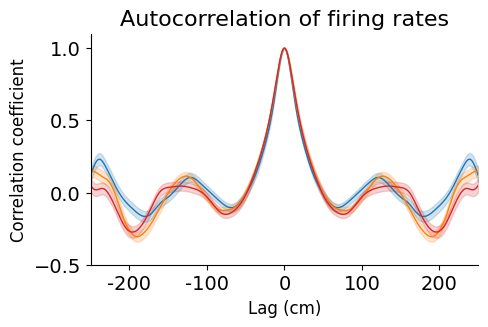

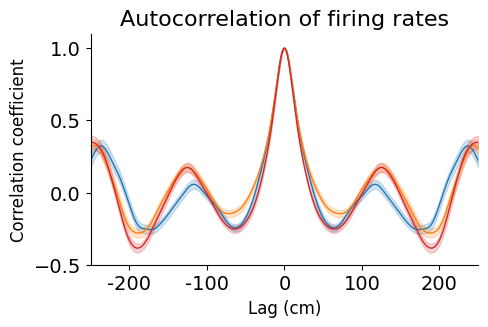

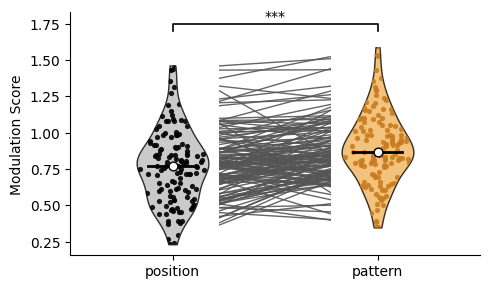

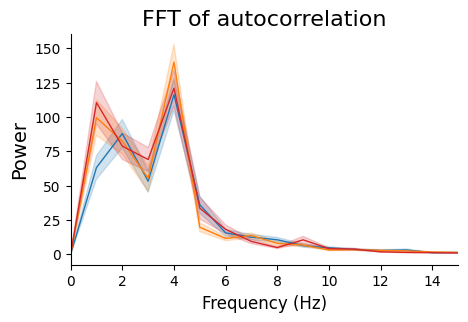

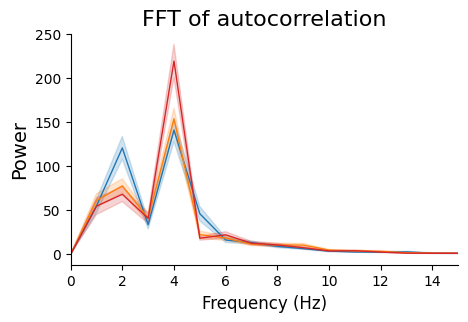

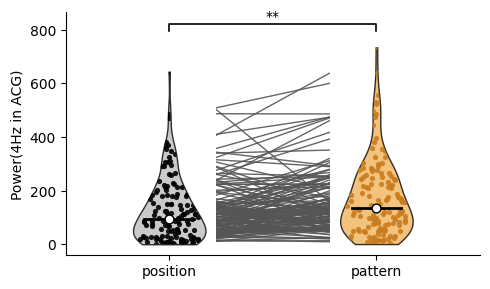

In [95]:
entry_dir = "../../data/flexible_shift/"

data1, mask1 = run_on(entry_dir, params, rule1="position", rule2="pattern", dist=dist, min_firing=min_firing)

minimum firing: 3
legal num: 752
total num: 1037
legal ratio: 0.7251687560270009
3Hz num: 178
3hz ratio: 0.23670212765957446


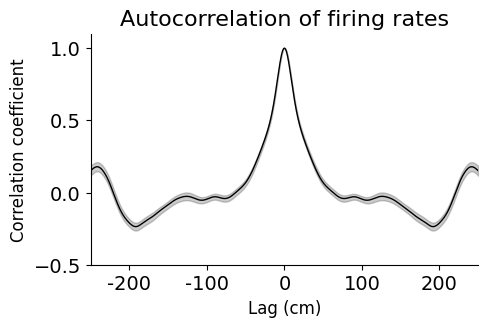

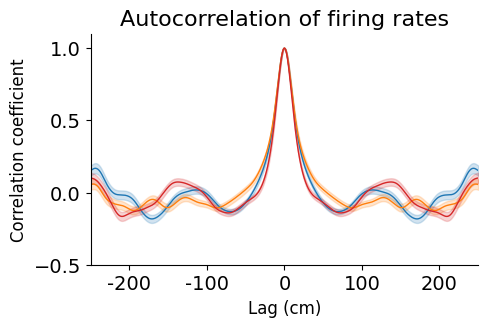

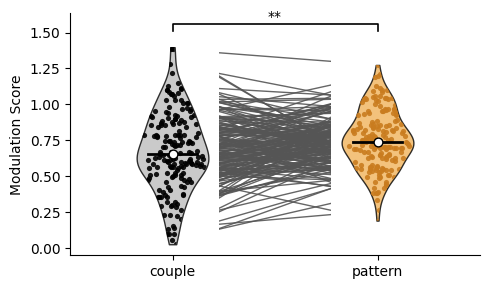

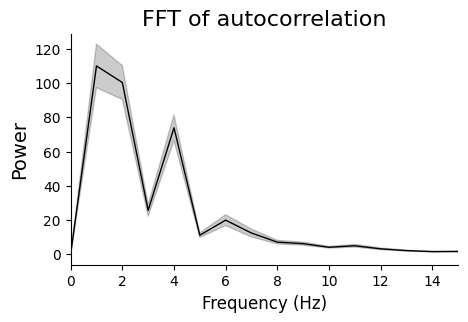

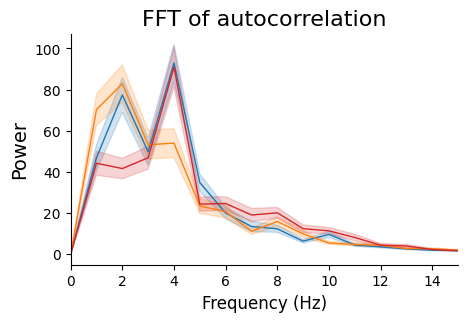

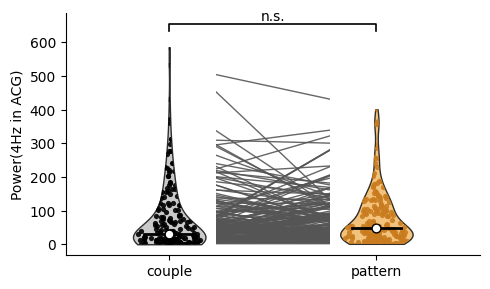

In [106]:
entry_dir = "../../data/first_to_pat/"

data2, mask2 = run_on(entry_dir, params, rule1="couple", rule2="pattern", dist=dist, min_firing=min_firing)

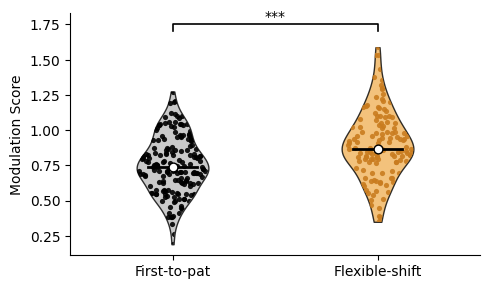

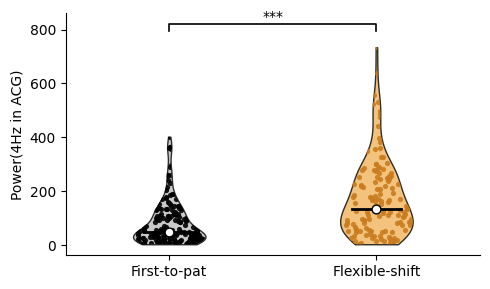

In [107]:
plot_unpaired_acg_test(params, data2, data1, rule1="pattern", rule2="pattern", mask1=mask2, mask2=mask1, dist=dist, labels=("First-to-pat", "Flexible-shift"))
plot_unpaired_acg_fft_test(params, data2, data1, rule1="pattern", rule2="pattern", mask1=mask2, mask2=mask1, labels=("First-to-pat", "Flexible-shift"))

In [98]:
def _downsample(data: np.ndarray, params: Params, axis: int):
    data = gaussian_filter1d(data, sigma=params.gaussian_sigma, axis=axis, mode='nearest', truncate=3.0)
    k = params.len_pos_average
    len_track = data.shape[axis]
    slices = [slice(None)] * data.ndim
    slices[axis] = slice(0, len_track - len_track % k)
    data = data[tuple(slices)]
    data = resample_poly(data, up=1, down=k, axis=axis)
    return data


def extract_trial_speed(data, params: Params, speeds: np.ndarray):
    
    trials = []
    
    speeds = _downsample(speeds, params, axis=1)

    for i in range(data['shape'][0]):
        for j in range(data['shape'][1]):
            
            fr = data['simple_firing'][i,j]
            if fr is None:
                continue
            
            fr = _downsample(fr, params, axis=2)
            
            is_selected = None
            for key in data["selection_in_rules"].keys():
                if key in params.tt[i]:
                    is_selected = data["selection_in_rules"][key]
                    break
            if is_selected is None:
                raise ValueError(f"No selection found for trial type {params.tt[i]}")
            
            fr = fr[is_selected,:,:]
            
            shape_ij = fr.shape
            num_trails = shape_ij[1]
            
            indexes = data['type_index'][i,j]
            
            for k in range(num_trails):
                
                trial_data = {
                    'trial_type': params.tt[i],
                    'behavior_type': params.bt[j],
                    'firing': fr[:,k,:],
                    'index': indexes[k],
                    'lick': data['pos_lick_type'][i,j][k],
                    'reward': data['pos_reward_type'][i,j][k],
                    'speed': speeds[indexes[k]],
                    'zones': data['zones'],
                }
                
                trials.append(trial_data)
                
    trials.sort(key=lambda t: t['index'])
    
    assert len(trials) == speeds.shape[0], "Mismatch between trials and speeds"
    
    return trials

def get_single_data(file_path: str, params: Params, rule1: str, rule2: str, min_firing: int, dist: int):
    data = load_pickle(file_path)
    data = extract_used_data(data)
    mergeAB(data)
    align_track(data, params)
    
    is_legal_firing1 = calc_if_firing_legal(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], min_firing=min_firing)
    is_legal_firing2 = calc_if_firing_legal(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], min_firing=min_firing)
    is_3hz1, valid1 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule1}*"], ana_bt=["correct"], dist=dist)
    is_3hz2, valid2 = calc_if_3Hz_oscillation(data, params, ana_tt=[f"{rule2}*"], ana_bt=["correct"], dist=dist)
    is_selected1 = (is_3hz1 & is_legal_firing1) & (valid1 & valid2)
    is_selected2 = (is_3hz2 & is_legal_firing2) & (valid1 & valid2)
    data['selection_in_rules'] = {f"{rule1}": is_selected1, f"{rule2}": is_selected2}

    mat_file_path = Path(file_path).parent / "speed" / f"{Path(file_path).stem.replace('PFCsep','').rstrip('-')}.mat"
    speeds = None
    try:
        if mat_file_path.exists():
            mat_data = sio.loadmat(mat_file_path)
            speeds = mat_data["speed_interp_trials"]
            speeds = np.squeeze(speeds)
            assert len(speeds.shape) == 1, "Unexpected speed data shape"
            speeds = np.array([np.squeeze(speeds[i]) for i in range(speeds.shape[0])])
        else:
            print(f"Missing file: {mat_file_path}")
    except Exception as e:
        print(f"Failed to load mat file {mat_file_path}: {e}")
    if speeds is None:
        raise ValueError("Speed data could not be loaded.")
    trials = extract_trial_speed(data, params, speeds)
    return trials


def get_data_in_row(entry_dir: str, params: Params, rule1: str, rule2: str, min_firing: int, dist: int):
    path = Path(entry_dir)
    trials_dict = {}
    for file in path.glob("*.pkl"):
        trials = get_single_data(str(file), params, rule1, rule2, min_firing, dist)
        trials_dict[file.stem] = trials
    return trials_dict

    

In [99]:
def _trial_to_Xy(trial, params: Params, period=120.0):
    """
    trial['firing']: (n_neurons, n_bins)
    trial['speed'] : (n_bins,)
    return:
      speed: (n_bins,)
      cyc  : (n_bins, 2) -> [sin(ωx), cos(ωx)]
      Y    : (n_bins, n_neurons)
    """
    Y = np.asarray(trial["firing"])
    
    if Y.ndim != 2:
        raise ValueError(f"trial['firing'] should be 2D, got {Y.shape}")
    Y = Y.T  # (n_bins, n_neurons)

    speed = np.asarray(trial["speed"]).reshape(-1)
    if speed.shape[0] != Y.shape[0]:
        raise ValueError(f"speed bins {speed.shape[0]} != firing bins {Y.shape[0]}")

    n_bins = Y.shape[0]
    x = np.arange(n_bins) * params.space_unit * params.len_pos_average  # cm

    theta = 2.0 * np.pi * (np.mod(x, period) / period)  # [0,2π)
    cyc = np.column_stack([np.sin(theta), np.cos(theta)])

    return speed, cyc, Y

def prepare_trial_mats(trials, params: Params, period=120.0):
    mats = []
    for t in trials:
        mats.append(_trial_to_Xy(t, params, period=period))
    # Basic consistency check
    n_neurons = mats[0][2].shape[1]
    n_bins = mats[0][2].shape[0]
    for ii, (_, _, Y) in enumerate(mats):
        if Y.shape[1] != n_neurons:
            raise ValueError(f"Trial {ii}: neuron count mismatch {Y.shape[1]} vs {n_neurons}")
        if Y.shape[0] != n_bins:
            raise ValueError(f"Trial {ii}: n_bins mismatch {Y.shape[0]} vs {n_bins}")
    return mats, n_neurons, n_bins

def _make_obs_model(obs):
    if obs == "poisson":
        return nmo.observation_models.PoissonObservations()
    if obs == "gamma":
        return nmo.observation_models.GammaObservations()
    if obs in ["neg-binomial", "negativebinomial", "nb"]:
        return nmo.observation_models.NegativeBinomialObservations()
    raise ValueError(f"Unknown obs={obs}")

def _ll_per_neuron_from_obs(obs_model, y, yhat):
    return np.asarray(
        obs_model.log_likelihood(
            y, yhat,
            aggregate_sample_scores=lambda ll: ll.sum(axis=0)
        )
    ).reshape(-1)

def init_params_logmean(X_tr, Y_tr, eps=1e-8):
    n_features = X_tr.shape[1]
    n_neurons  = Y_tr.shape[1]
    coef0 = jnp.zeros((n_features, n_neurons))

    mean_rate = jnp.mean(jnp.asarray(Y_tr), axis=0)
    mean_rate = jnp.clip(mean_rate, eps, None)

    # exp inverse-link（log link）:  intercept = log(mean)
    intercept0 = jnp.log(mean_rate)

    return (coef0, intercept0)

def cv_compare_models_population(
    trials, params: Params, period=120.0,
    obs="gamma",
    regularizer="Ridge",
    regularizer_strength=0.1,
    n_splits=5,
    seed=0,
):
    mats, n_neurons, _ = prepare_trial_mats(trials, params, period=period)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    trial_idx = np.arange(len(mats))

    ll_full  = np.zeros(n_neurons, dtype=float)
    ll_speed = np.zeros(n_neurons, dtype=float)
    ll_cyc   = np.zeros(n_neurons, dtype=float)
    ll_null  = np.zeros(n_neurons, dtype=float)

    n_test_bins_total = 0
    n_test_trials_total = 0

    obs_model = _make_obs_model(obs)

    for fold, (tr_i, te_i) in enumerate(kf.split(trial_idx), 1):
        sp_tr = np.concatenate([mats[i][0] for i in tr_i], axis=0)
        sp_te = np.concatenate([mats[i][0] for i in te_i], axis=0)

        mu, sd = sp_tr.mean(), sp_tr.std() + 1e-12
        sp_tr_z = (sp_tr - mu) / sd
        sp_te_z = (sp_te - mu) / sd

        cyc_tr = np.concatenate([mats[i][1] for i in tr_i], axis=0)
        cyc_te = np.concatenate([mats[i][1] for i in te_i], axis=0)

        Y_tr = np.concatenate([mats[i][2] for i in tr_i], axis=0)
        Y_te = np.concatenate([mats[i][2] for i in te_i], axis=0)

        # count test size (for normalization)
        n_test_bins_total += Y_te.shape[0]
        n_test_trials_total += len(te_i)

        X_full_tr  = np.column_stack([sp_tr_z, cyc_tr])
        X_full_te  = np.column_stack([sp_te_z, cyc_te])
        X_speed_tr = sp_tr_z[:, None]
        X_speed_te = sp_te_z[:, None]
        X_cyc_tr   = cyc_tr
        X_cyc_te   = cyc_te

        X_null_tr  = np.zeros((Y_tr.shape[0], 1))
        X_null_te  = np.zeros((Y_te.shape[0], 1))

        # init params
        init_full  = init_params_logmean(X_full_tr,  Y_tr)
        init_speed = init_params_logmean(X_speed_tr, Y_tr)
        init_cyc   = init_params_logmean(X_cyc_tr,   Y_tr)
        init_null  = init_params_logmean(X_null_tr,  Y_tr)

        if obs is not None and obs.lower() == "gamma":
            Y_tr = np.clip(Y_tr, 1e-5, None)
            Y_te = np.clip(Y_te, 1e-5, None)

        kw = dict(regularizer=regularizer, regularizer_strength=regularizer_strength)

        m_full  = nmo.glm.PopulationGLM(observation_model=obs_model, **kw).fit(X_full_tr,  Y_tr, init_params=init_full)
        m_speed = nmo.glm.PopulationGLM(observation_model=obs_model, **kw).fit(X_speed_tr, Y_tr, init_params=init_speed)
        m_cyc   = nmo.glm.PopulationGLM(observation_model=obs_model, **kw).fit(X_cyc_tr,   Y_tr, init_params=init_cyc)
        m_null  = nmo.glm.PopulationGLM(observation_model=obs_model, **kw).fit(X_null_tr,  Y_tr, init_params=init_null)

        r_full  = m_full.predict(X_full_te)
        r_speed = m_speed.predict(X_speed_te)
        r_cyc   = m_cyc.predict(X_cyc_te)
        r_null  = m_null.predict(X_null_te)

        ll_full  += _ll_per_neuron_from_obs(obs_model, Y_te, r_full)
        ll_speed += _ll_per_neuron_from_obs(obs_model, Y_te, r_speed)
        ll_cyc   += _ll_per_neuron_from_obs(obs_model, Y_te, r_cyc)
        ll_null  += _ll_per_neuron_from_obs(obs_model, Y_te, r_null)

    # normalized (per bin)
    denom_bins = max(int(n_test_bins_total), 1)
    ll_full_per_bin  = ll_full  / denom_bins
    ll_speed_per_bin = ll_speed / denom_bins
    ll_cyc_per_bin   = ll_cyc   / denom_bins
    ll_null_per_bin  = ll_null  / denom_bins

    delta_speed = ll_full - ll_cyc
    delta_cyc   = ll_full - ll_speed
    delta_speed_per_bin = delta_speed / denom_bins
    delta_cyc_per_bin   = delta_cyc   / denom_bins

    # pseudo R^2 (McFadden) vs null
    eps_ll = 1e-12
    pseudo_r2_full  = 1.0 - (ll_full  / (ll_null + eps_ll))
    pseudo_r2_speed = 1.0 - (ll_speed / (ll_null + eps_ll))
    pseudo_r2_cyc   = 1.0 - (ll_cyc   / (ll_null + eps_ll))

    # partial (relative improvement over reduced, normalized by remaining room to null)
    partial_r2_speed_given_cyc = (ll_full - ll_cyc) / (ll_null - ll_cyc + eps_ll)
    partial_r2_cyc_given_speed = (ll_full - ll_speed) / (ll_null - ll_speed + eps_ll)

    return {
        "ll_full": ll_full,
        "ll_speed_only": ll_speed,
        "ll_cyc_only": ll_cyc,
        "ll_null": ll_null,

        "ll_full_per_bin": ll_full_per_bin,
        "ll_speed_only_per_bin": ll_speed_per_bin,
        "ll_cyc_only_per_bin": ll_cyc_per_bin,
        "ll_null_per_bin": ll_null_per_bin,

        "delta_ll_speed_given_cyc": delta_speed,
        "delta_ll_cyc_given_speed": delta_cyc,
        "delta_ll_speed_given_cyc_per_bin": delta_speed_per_bin,
        "delta_ll_cyc_given_speed_per_bin": delta_cyc_per_bin,

        "pseudo_r2_full": pseudo_r2_full,
        "pseudo_r2_speed_only": pseudo_r2_speed,
        "pseudo_r2_cyc_only": pseudo_r2_cyc,

        "partial_r2_speed_given_cyc": partial_r2_speed_given_cyc,
        "partial_r2_cyc_given_speed": partial_r2_cyc_given_speed,

        "n_test_bins_total": int(n_test_bins_total),
        "n_test_trials_total": int(n_test_trials_total),

        "settings": dict(period=period, obs=obs, regularizer=regularizer,
                         regularizer_strength=regularizer_strength,
                         n_splits=n_splits, seed=seed),
    }

    

In [100]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()


def glm_analysis_parallel(
    trials_dict,
    params,
    rule1,
    rule2,
    obs="poisson",
    behavior_type="correct",
    n_jobs=-1,
    backend="loky",
):
    def _one_job(rule_trials):
        cv_results = cv_compare_models_population(rule_trials, params, obs=obs)
        return cv_results

    # build tasks
    tasks = []
    for key in trials_dict.keys():
        trials = [t for t in trials_dict[key] if t.get("behavior_type") == behavior_type]
        rule1_trials = [t for t in trials if rule1 in t.get("trial_type", "")]
        rule2_trials = [t for t in trials if rule2 in t.get("trial_type", "")]
        for rule_trials in (rule1_trials, rule2_trials):
            if len(rule_trials) == 0:
                continue
            tasks.append(rule_trials)

    if len(tasks) == 0:
        raise ValueError("No tasks found (check rule1/rule2/behavior_type filters).")

    # run in parallel
    with tqdm_joblib(tqdm(total=len(tasks), desc="CV per group")):
        results = Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(_one_job)(rt) for rt in tasks
        )


    return results

In [101]:
# entry_dir = "../../data/flexible_shift/"
# rule1 = "pattern"
# rule2 = "position"
# params = set_params(tt_preset='merge',
#                     bt_preset='basic',
#                     len_pos_average=1,
#                     gaussian_sigma=50)
# min_firing = 3
# dist = int(125 * 2 / params.space_unit)
# trials_dict = get_data_in_row(entry_dir, params, rule1, rule2, min_firing, dist)

In [102]:
# results = glm_analysis_parallel(trials_dict, params, rule1, rule2)

In [103]:
def plot_violin_groups(
    groups,
    labels=None,
    ylabel="",
    title=None,
    widths=0.42,
    violin_colors=None,
    point_colors=None,
    seed=0,
    eps=0.97,
    show_median=True,
    show_points=True,
    point_size=14,
    edge_color="k",
    alpha=0.3,
):
    groups = [np.asarray(g, float) for g in groups]
    n_groups = len(groups)
    if n_groups < 1:
        raise ValueError("groups is empty")

    if labels is None:
        labels = [f"Group{i+1}" for i in range(n_groups)]
    if len(labels) != n_groups:
        raise ValueError("labels length must match number of groups")

    fig = plt.figure(figsize=(4.0 + 0.6 * n_groups, 4.0))
    ax = fig.gca()
    positions = np.arange(1, n_groups + 1, dtype=float)

    # ---- violin bodies ----
    parts = ax.violinplot(
        groups,
        positions=positions,
        widths=widths,
        showmeans=False,
        showmedians=False,
        showextrema=False,
    )
    bodies = parts["bodies"]

    default_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3","C4","C5"])
    auto_colors = [default_cycle[i % len(default_cycle)] for i in range(n_groups)]

    if violin_colors is None:
        violin_colors = [None] * n_groups
    if len(violin_colors) < n_groups:
        raise ValueError("violin_colors length must be >= number of groups")

    if point_colors is not None and len(point_colors) < n_groups:
        raise ValueError("point_colors length must be >= number of groups")

    resolved_point_colors = []

    for i, body in enumerate(bodies):
        vc = violin_colors[i]

        # facecolor: 默认透明
        if vc is None:
            body.set_facecolor("none")       # 关键：无背景
        else:
            body.set_facecolor(vc)

        body.set_edgecolor(edge_color)
        body.set_linewidth(1.0)
        body.set_alpha(alpha if vc is not None else 1.0)
        body.set_zorder(1)

        if point_colors is None:
            pc = vc if vc is not None else auto_colors[i]
        else:
            pc = point_colors[i]
        resolved_point_colors.append(pc)

    def halfwidth_fn_from_body(body, center_x):
        verts = body.get_paths()[0].vertices
        ok = np.isfinite(verts).all(axis=1)
        verts = verts[ok]
        if verts.shape[0] == 0:
            return lambda yy: widths / 2

        yv = verts[:, 1]
        hw = np.abs(verts[:, 0] - center_x)
        hw = np.clip(hw, 0, widths / 2)

        order = np.argsort(yv)
        yv = yv[order]
        hw = hw[order]

        f = interp1d(
            yv, hw,
            kind="linear",
            bounds_error=False,
            fill_value=(float(np.min(hw)), float(np.max(hw))),
        )

        def safe_hw(yy):
            val = f(yy)
            if not np.isfinite(val):
                return widths / 2
            return float(np.clip(val, 0, widths / 2))
        return safe_hw

    rng = np.random.default_rng(seed)

    for i, (g, pos, body) in enumerate(zip(groups, positions, bodies)):
        if show_points:
            hw_fn = halfwidth_fn_from_body(body, pos)
            max_j = widths / 2 * eps

            xj = np.empty_like(g, dtype=float)
            for k in range(g.size):
                local_hw = hw_fn(g[k])
                lim = min(local_hw * eps, max_j)
                lim = max(lim, 1e-6)
                xj[k] = pos + rng.uniform(-lim, lim)

            sc = ax.scatter(
                xj, g,
                s=point_size,
                color=resolved_point_colors[i],
                linewidths=0,
                zorder=2,
            )
            sc.set_clip_path(body.get_paths()[0], body.get_transform())

        if show_median:
            med = float(np.median(g))
            ax.plot([pos-0.14, pos+0.14], [med, med], color="k", lw=2, zorder=3)
            ax.scatter([pos], [med], s=42, color="white", edgecolor="k", zorder=4)

    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=14)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=14)
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(0.5, n_groups + 0.5)
    remove_top_right_spines(ax)
    plt.tight_layout()
    plt.show()


In [104]:
# pseudo_r2_full = np.concatenate([res["pseudo_r2_full"] for res in results])
# pseudo_r2_speed_only = np.concatenate([res["pseudo_r2_speed_only"] for res in results])
# pseudo_r2_cyc_only = np.concatenate([res["pseudo_r2_cyc_only"] for res in results])
# plot_violin_groups(
#     [pseudo_r2_full, pseudo_r2_speed_only, pseudo_r2_cyc_only],
#     labels=["Full", "Speed only", "Cyc only"],
#     ylabel="Pseudo-R²",
#     title="Model explained variance",
# )